In [1]:
%%capture
!pip install neptune-client psutil
!git clone https://github.com/Cho-D-YoungRae/URP_PD.git
%cd URP_PD

In [2]:
import dataset
import object_detection
from utils import *
import eval

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
import torch.nn.functional as F
from torchvision.utils import make_grid

import os
import json
import numpy as np
import argparse
from tqdm.auto import tqdm
import time
from datetime import datetime

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using <{device}> device")

loading annotations into memory...
Done (t=0.10s)
creating index...
index created!
Using <cpu> device


In [3]:
# ====== constants ======#
label_map = {'background': 0, 'person': 1}
rev_label_map = {v: k for k, v in label_map.items()} 

## setting

In [4]:
from torch.backends import cudnn
import random

cudnn.benchmark = True

# ====== Random Seed Initialization ====== #
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
random.seed(seed)

# torch.cuda.manual_seed(seed)
# torch.cuda.manual_seed_all(seed)
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False

parser = argparse.ArgumentParser()
args = parser.parse_args("")
# args.baselineID = 27

# ====== Dataset ====== #
args.ch_option = {'num_ch': 1,
                  'img_type': 'lwir',
                  'one_ch_option': 'mean'}
args.val_split = 0.1

# ====== Model ====== #
args.base_model = 'VGG16bnBase'
args.n_classes = len(label_map)
args.is_sds = True
args.usages_seg_feats = [True, True, False, False, False, False]


# ====== Optimizer & Training ====== #
args.optim = 'Adam'
args.lr = 5e-4
args.twice_b_lr = True
args.weight_decay = 5e-4

args.epochs = 100
args.train_batch_size = 32
args.test_batch_size = 64

args.decay_lr_at = [int(args.epochs/6)*4,
                    int(args.epochs/6)*5]
args.decay_lr_to = 0.1

## dataset init

In [5]:
workers = 4
train_dataset = dataset.KaistPDDataset(ch_option=args.ch_option,
                                       is_sds=args.is_sds)
train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=args.train_batch_size, 
                                           shuffle=True,
                                           collate_fn=dataset.sds_collate_fn,
                                           num_workers=workers,
                                           pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## check


In [6]:
for i, (images, bboxes, category_ids, is_crowds, seg_labels) in enumerate(train_loader):
    break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


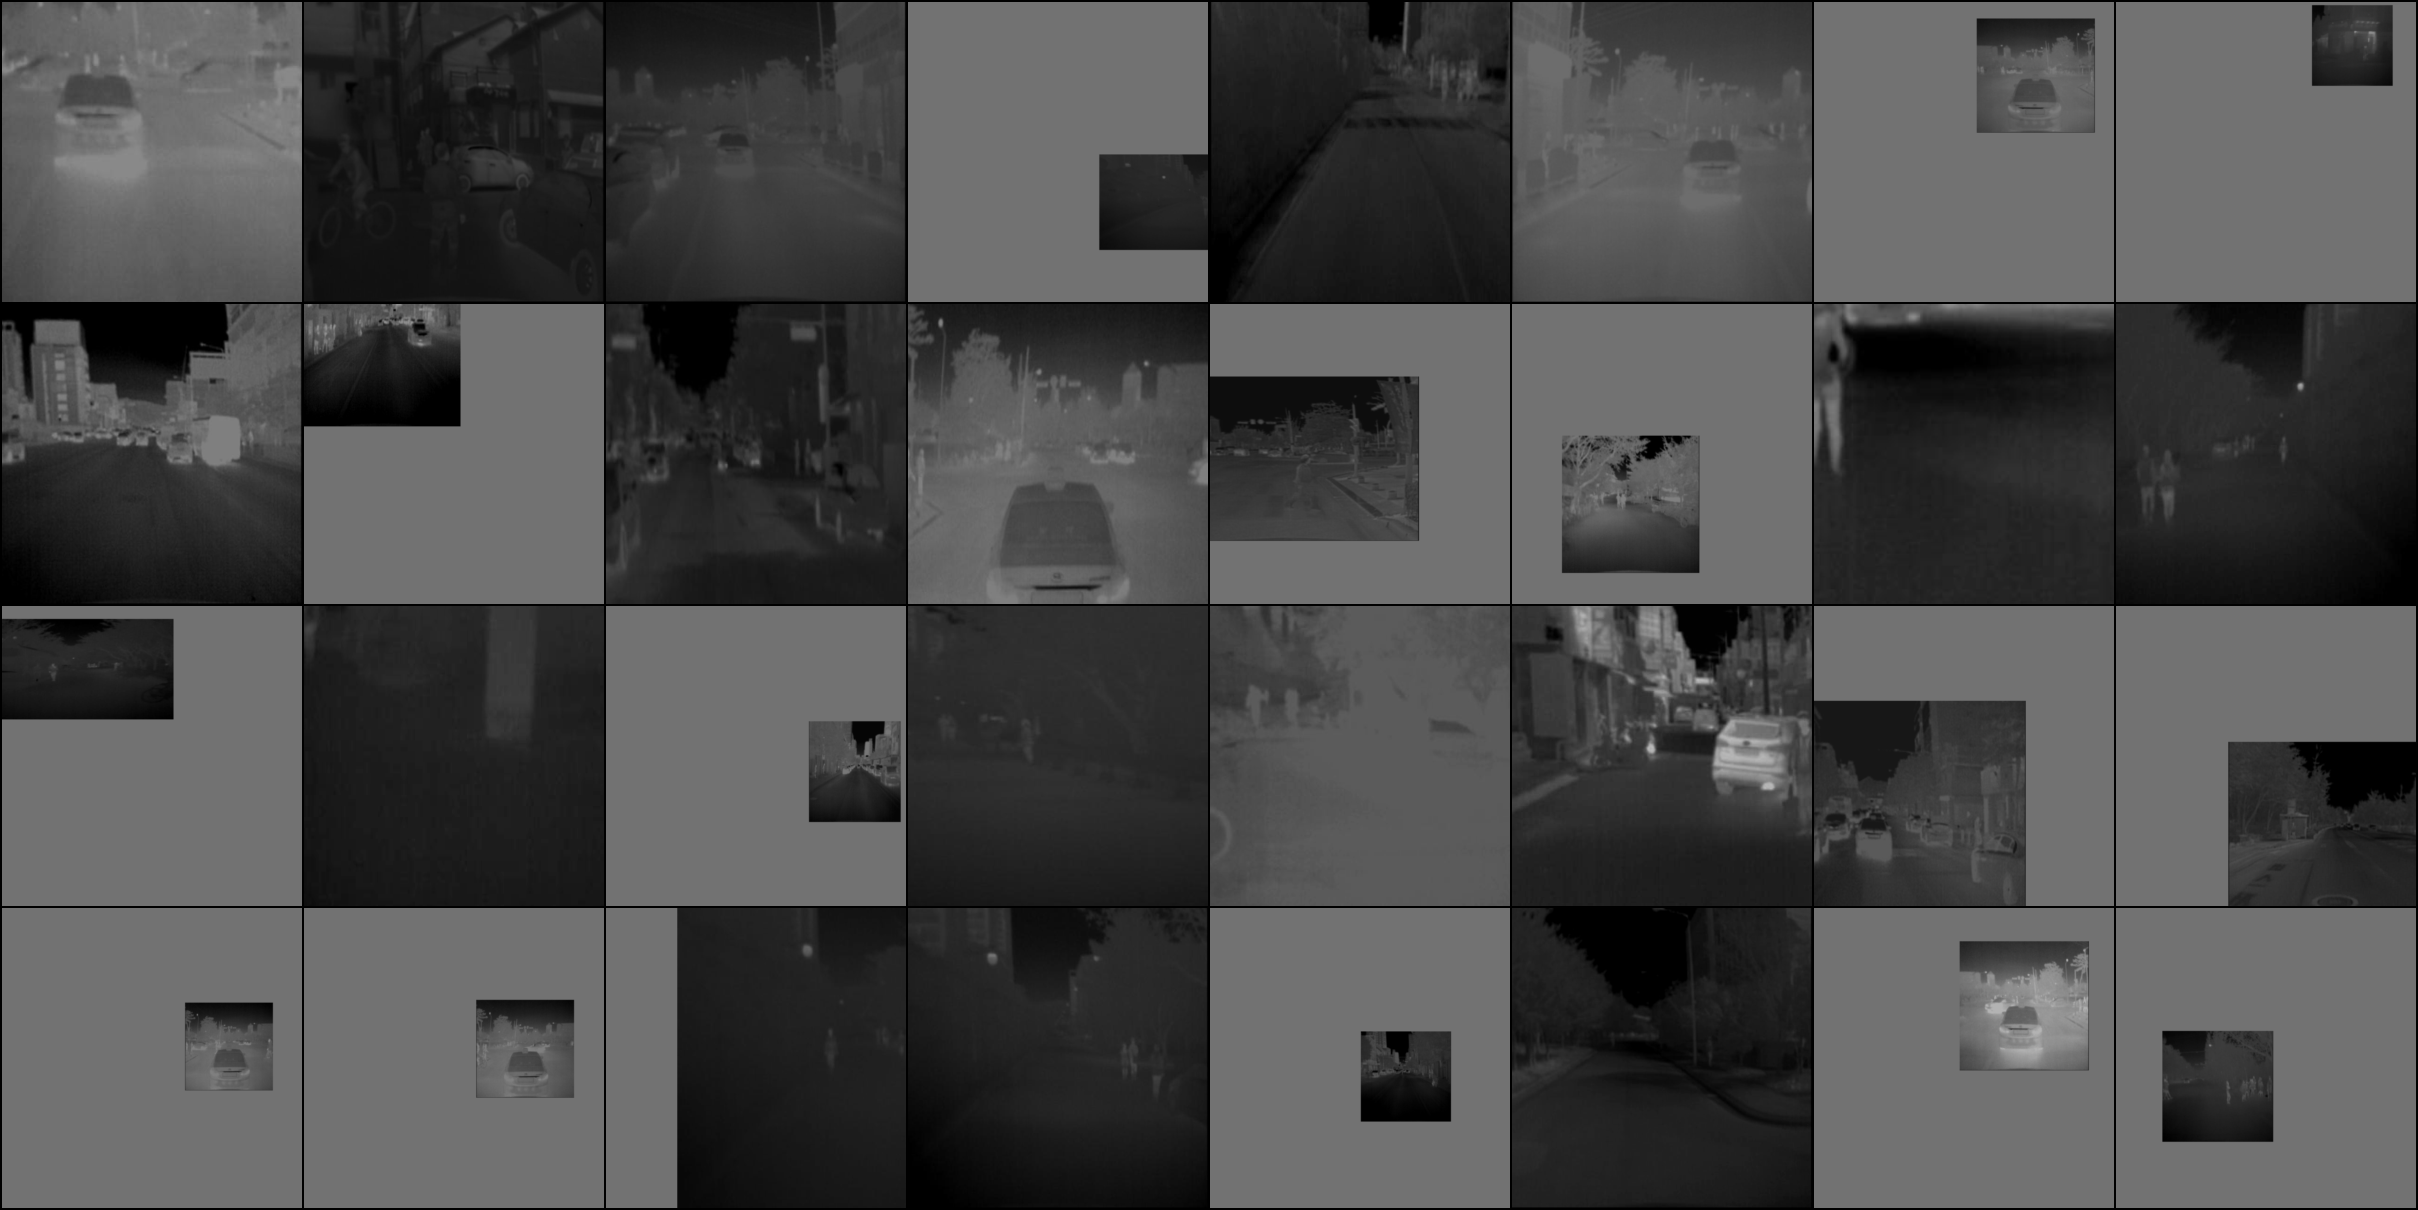

In [7]:
TF.to_pil_image(make_grid(images))

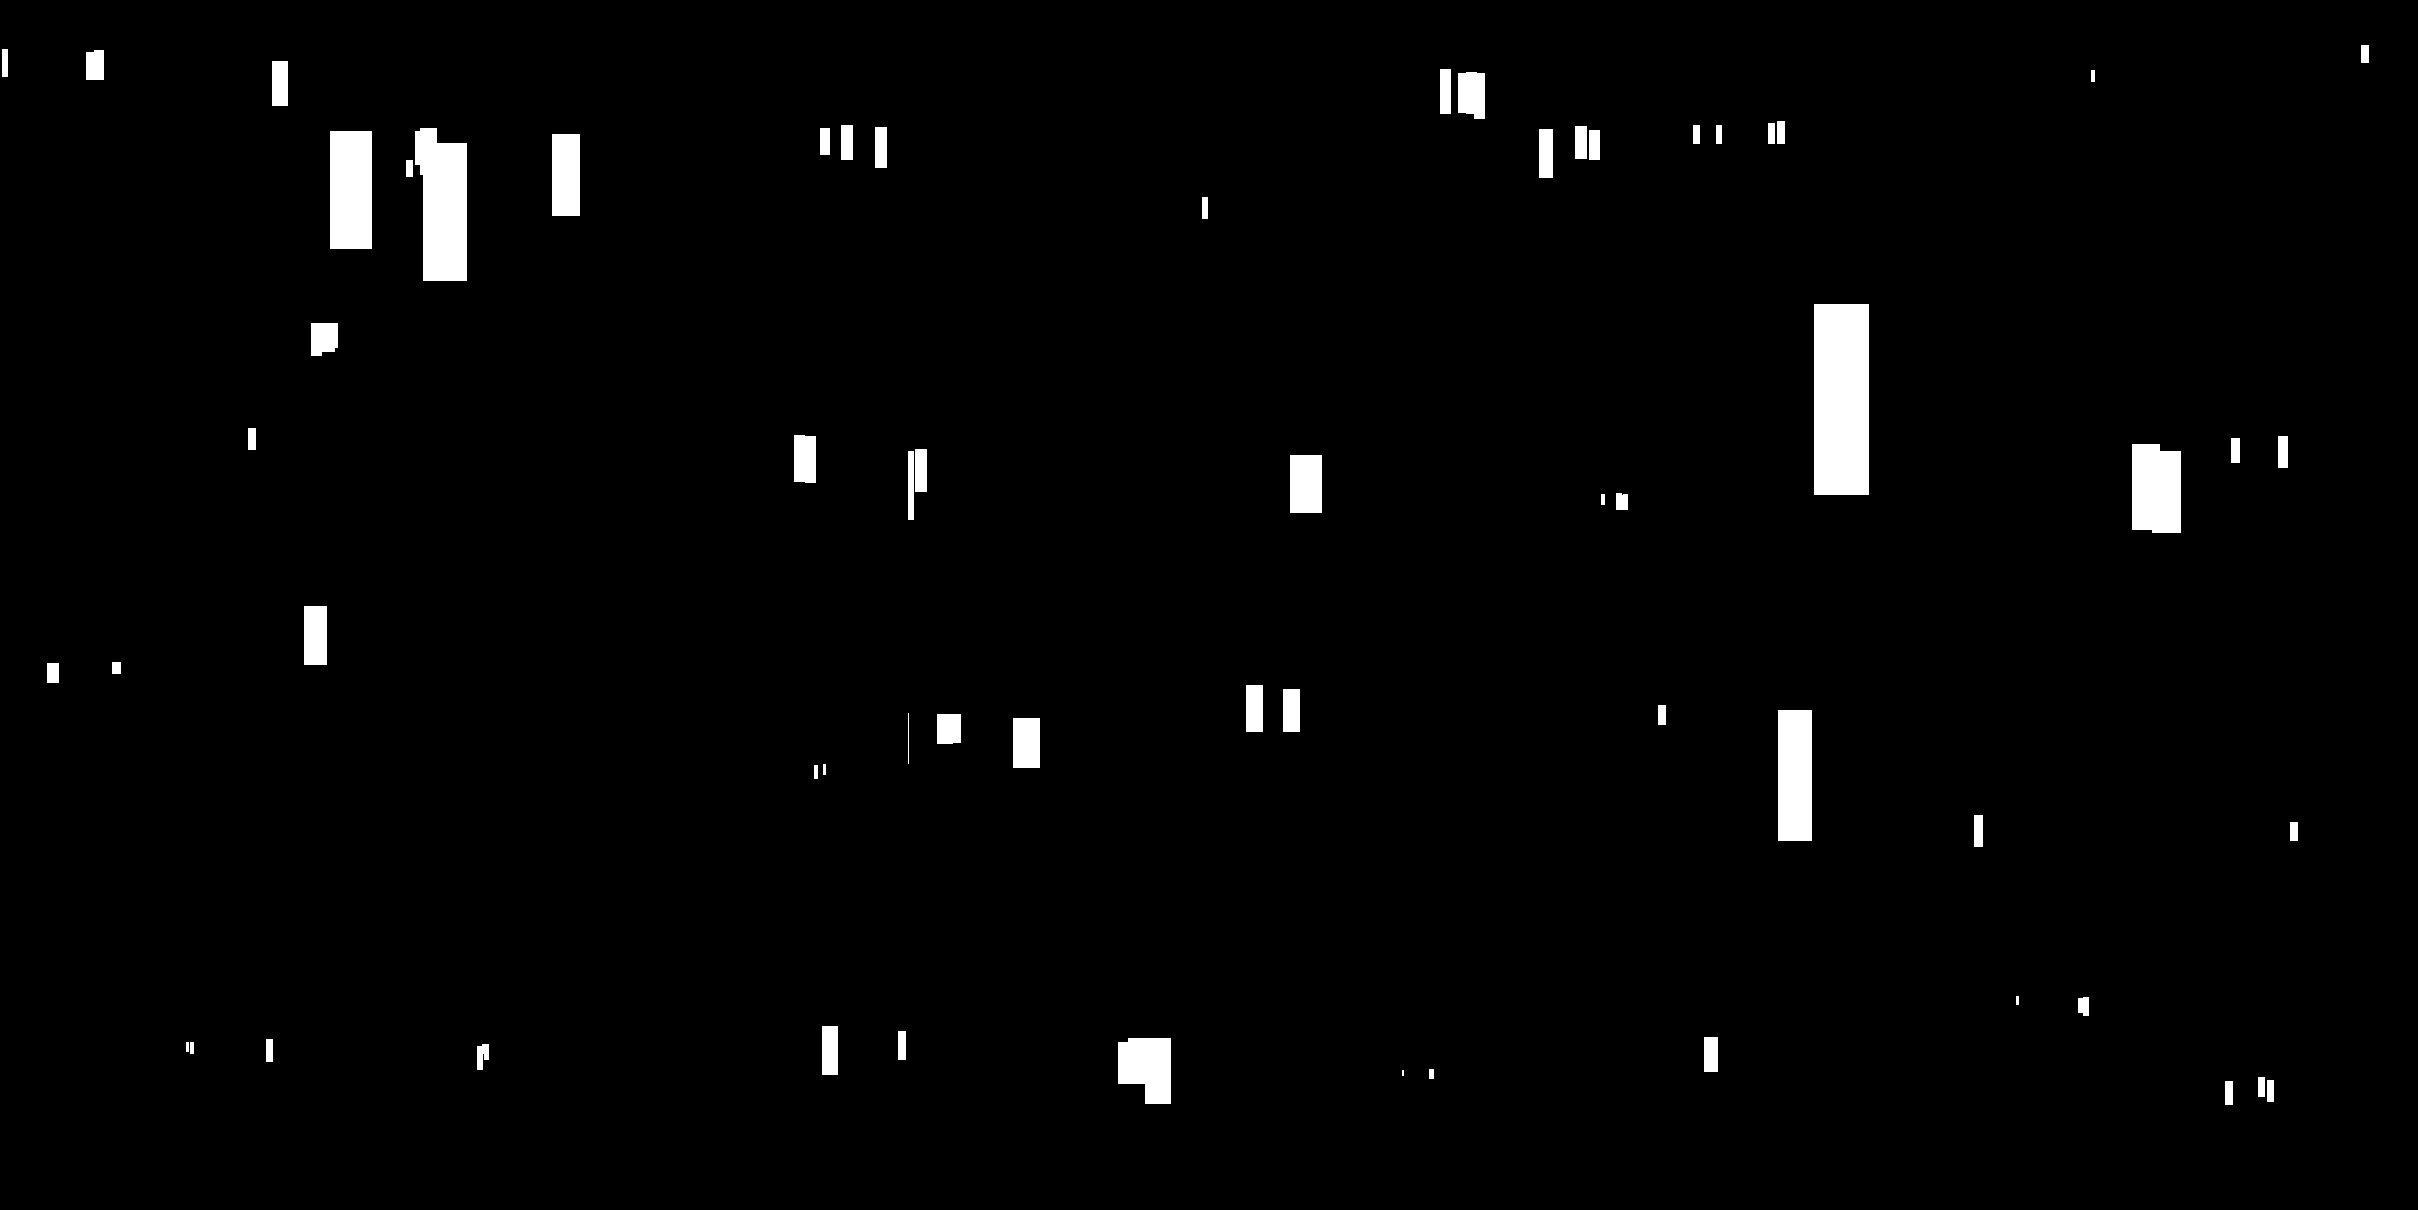

In [8]:
TF.to_pil_image(make_grid(seg_labels))

In [9]:
bboxes[0]

tensor([[0.8990, 0.1944, 0.9507, 0.3426],
        [0.2783, 0.1667, 0.3079, 0.2562],
        [0.3054, 0.1574, 0.3374, 0.2562]])

In [10]:
category_ids[0]

tensor([1, 1, 1])

In [11]:
def limit_point_boundary(bbox, boundary=(0, 0, 300, 300)):
    for i in range(2):
        if bbox[i] < 0:
            bbox[i] = 0
    for i in range(2, 4):
        if bbox[i] > 300:
            bbox[i] = 300

    return bbox

def get_all_objects(images, bboxes):
    img_w, img_h = images.size(3), images.size(2)
    dims = torch.FloatTensor((img_w, img_h, img_w, img_h)).unsqueeze(0)
    bboxes = map(lambda x: torch.round(dims * x), bboxes)
    
    all_objects = []
    img_idx = []
    for i, (image, bboxes_in_img) in enumerate(zip(images, bboxes)):
        for bbox in bboxes_in_img:
            bbox = torch.round(bbox).long()
            x_min, y_min, x_max, y_max = limit_point_boundary(bbox)
            obj = image[:, y_min:y_max+1, x_min:x_max+1]
            img_idx.append(i)
            all_objects.append(obj)

    return all_objects, img_idx

In [12]:
def flip_objects(all_objects):
    for i in range(len(all_objects)):
        if random.random() < 0.5:
            all_objects[i] = torch.flip(all_objects[i], dims=(0, 2))

    return all_objects

In [13]:
def get_to_imgs(img_idxs, batch_size):
    counts = [0] * batch_size
    for i in img_idxs:
        counts[i] += 1
    max_count, min_count = max(counts), min(counts)
    weights = [max_count - count + min_count for count in counts]
    to_imgs = random.choices(
        range(batch_size), weights=weights, k=len(img_idxs))
    
    return to_imgs

In [14]:
def copy_paste_aug(images, bboxes, category_ids, seg_labels,
                   max_paste_try=5,
                   resize_min_max=(0.8, 2),
                   max_overlap=0
                   ):
    batch_size, num_ch, img_h, img_w = images.size()
    img_dim = torch.Tensor([img_w, img_h, img_w, img_h])
    all_objects, img_idxs = get_all_objects(images, bboxes)
    all_objects = flip_objects(all_objects)
    to_imgs = get_to_imgs(img_idxs, batch_size)

    for obj, to_img in zip(all_objects, to_imgs):
        _, obj_h, obj_w = obj.size()
        max_rescale = min(img_w / obj_w, img_h / obj_h)
        bboxes_in_img = bboxes[to_img]  # Tensor (n_objects, 4)
        cat_ids_in_img = category_ids[to_img]
        for _ in range(max_paste_try):
            rescale = random.uniform(*resize_min_max)
            rescale = min(rescale, max_rescale)
            r_h, r_w = int(rescale*obj_h), int(rescale*obj_w)
            r_h = 1 if r_h == 0 else r_h
            r_w = 1 if r_w == 0 else r_w
            resize_obj = F.interpolate(
                obj.unsqueeze(0), size=(r_h, r_w), mode='nearest'
            ).squeeze(0)
            paste_x = random.randint(0, img_w - r_w)
            paste_y = random.randint(0, img_h - r_h)
            paste_box = torch.Tensor(
                [paste_x, paste_y, paste_x+r_w, paste_y+r_h])   # (4,)
            scaled_paste_box = (paste_box / img_dim).unsqueeze(0)   # (1, 4)
            overlaps = find_jaccard_overlap(
                scaled_paste_box, bboxes_in_img
            )
            if overlaps.max().item() <= max_overlap:
                x_min, y_min, x_max, y_max = paste_box.long()
                seg_labels[to_img, 0, y_min:y_max, x_min:x_max] = 1
                images[to_img, :, y_min:y_max, x_min:x_max] = resize_obj
                bboxes_in_img = torch.cat((bboxes_in_img, scaled_paste_box))
                bboxes[to_img] = bboxes_in_img
                cat_ids_in_img = torch.cat((cat_ids_in_img,
                                           torch.LongTensor([1])))
                category_ids[to_img] = cat_ids_in_img
                break
            

    return images, bboxes, category_ids, seg_labels

In [15]:
torch.cat((category_ids[0], torch.LongTensor([1])))

tensor([1, 1, 1, 1])

In [16]:
torch.LongTensor([1])

tensor([1])

In [17]:
category_ids[0].dtype

torch.int64

In [18]:
images, bboxes, category_ids, seg_labels = \
    copy_paste_aug(images, bboxes, category_ids, seg_labels)

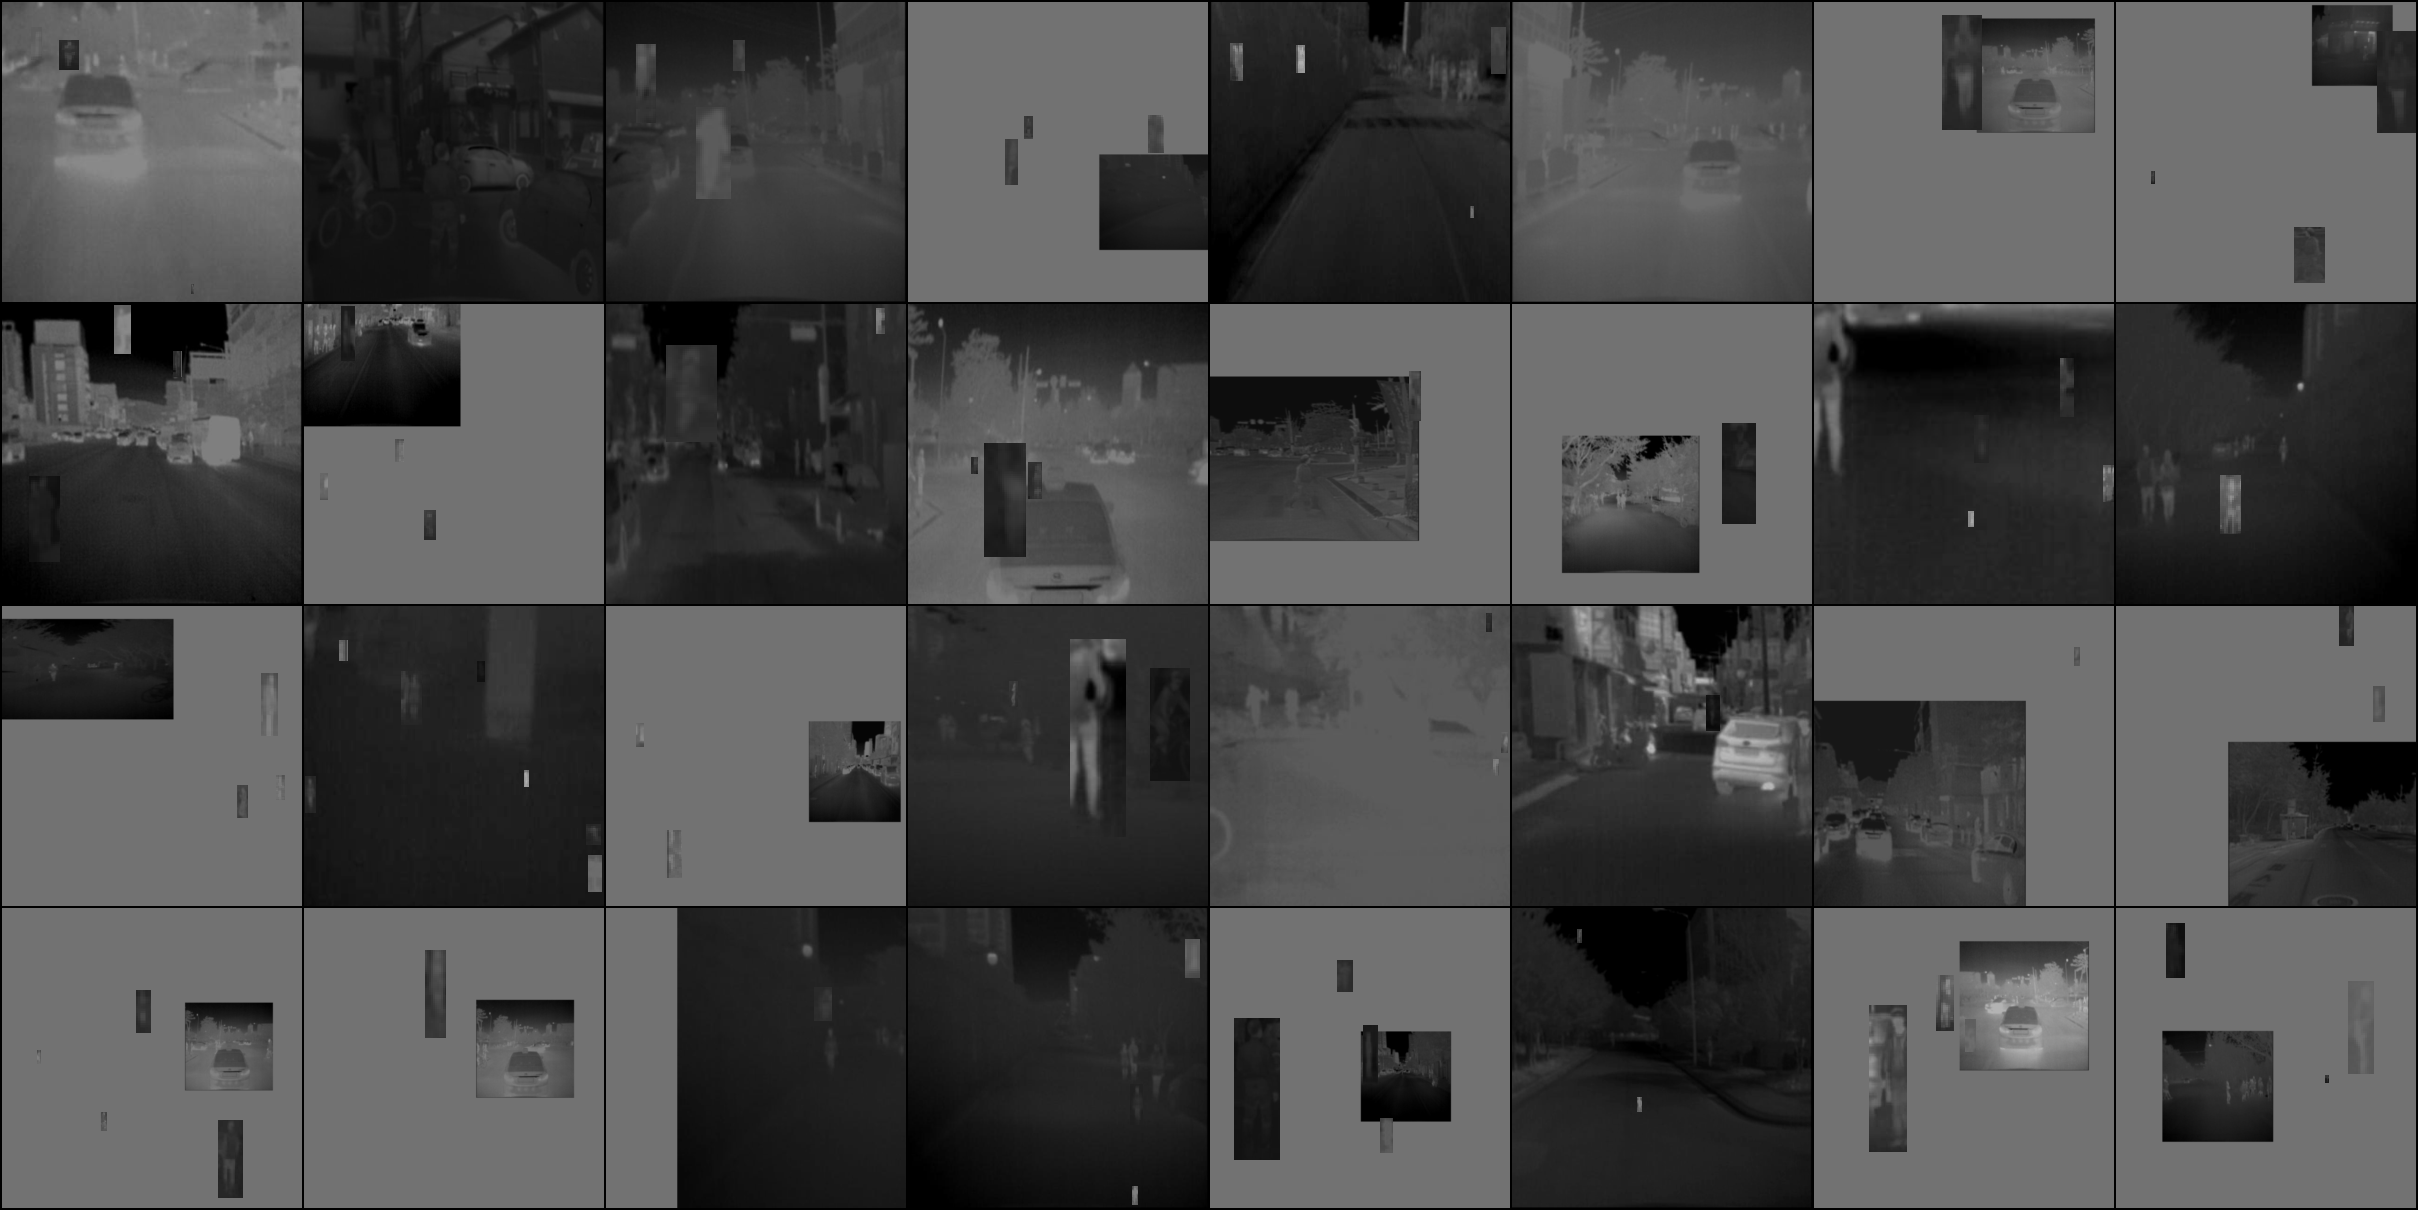

In [19]:
TF.to_pil_image(make_grid(images))

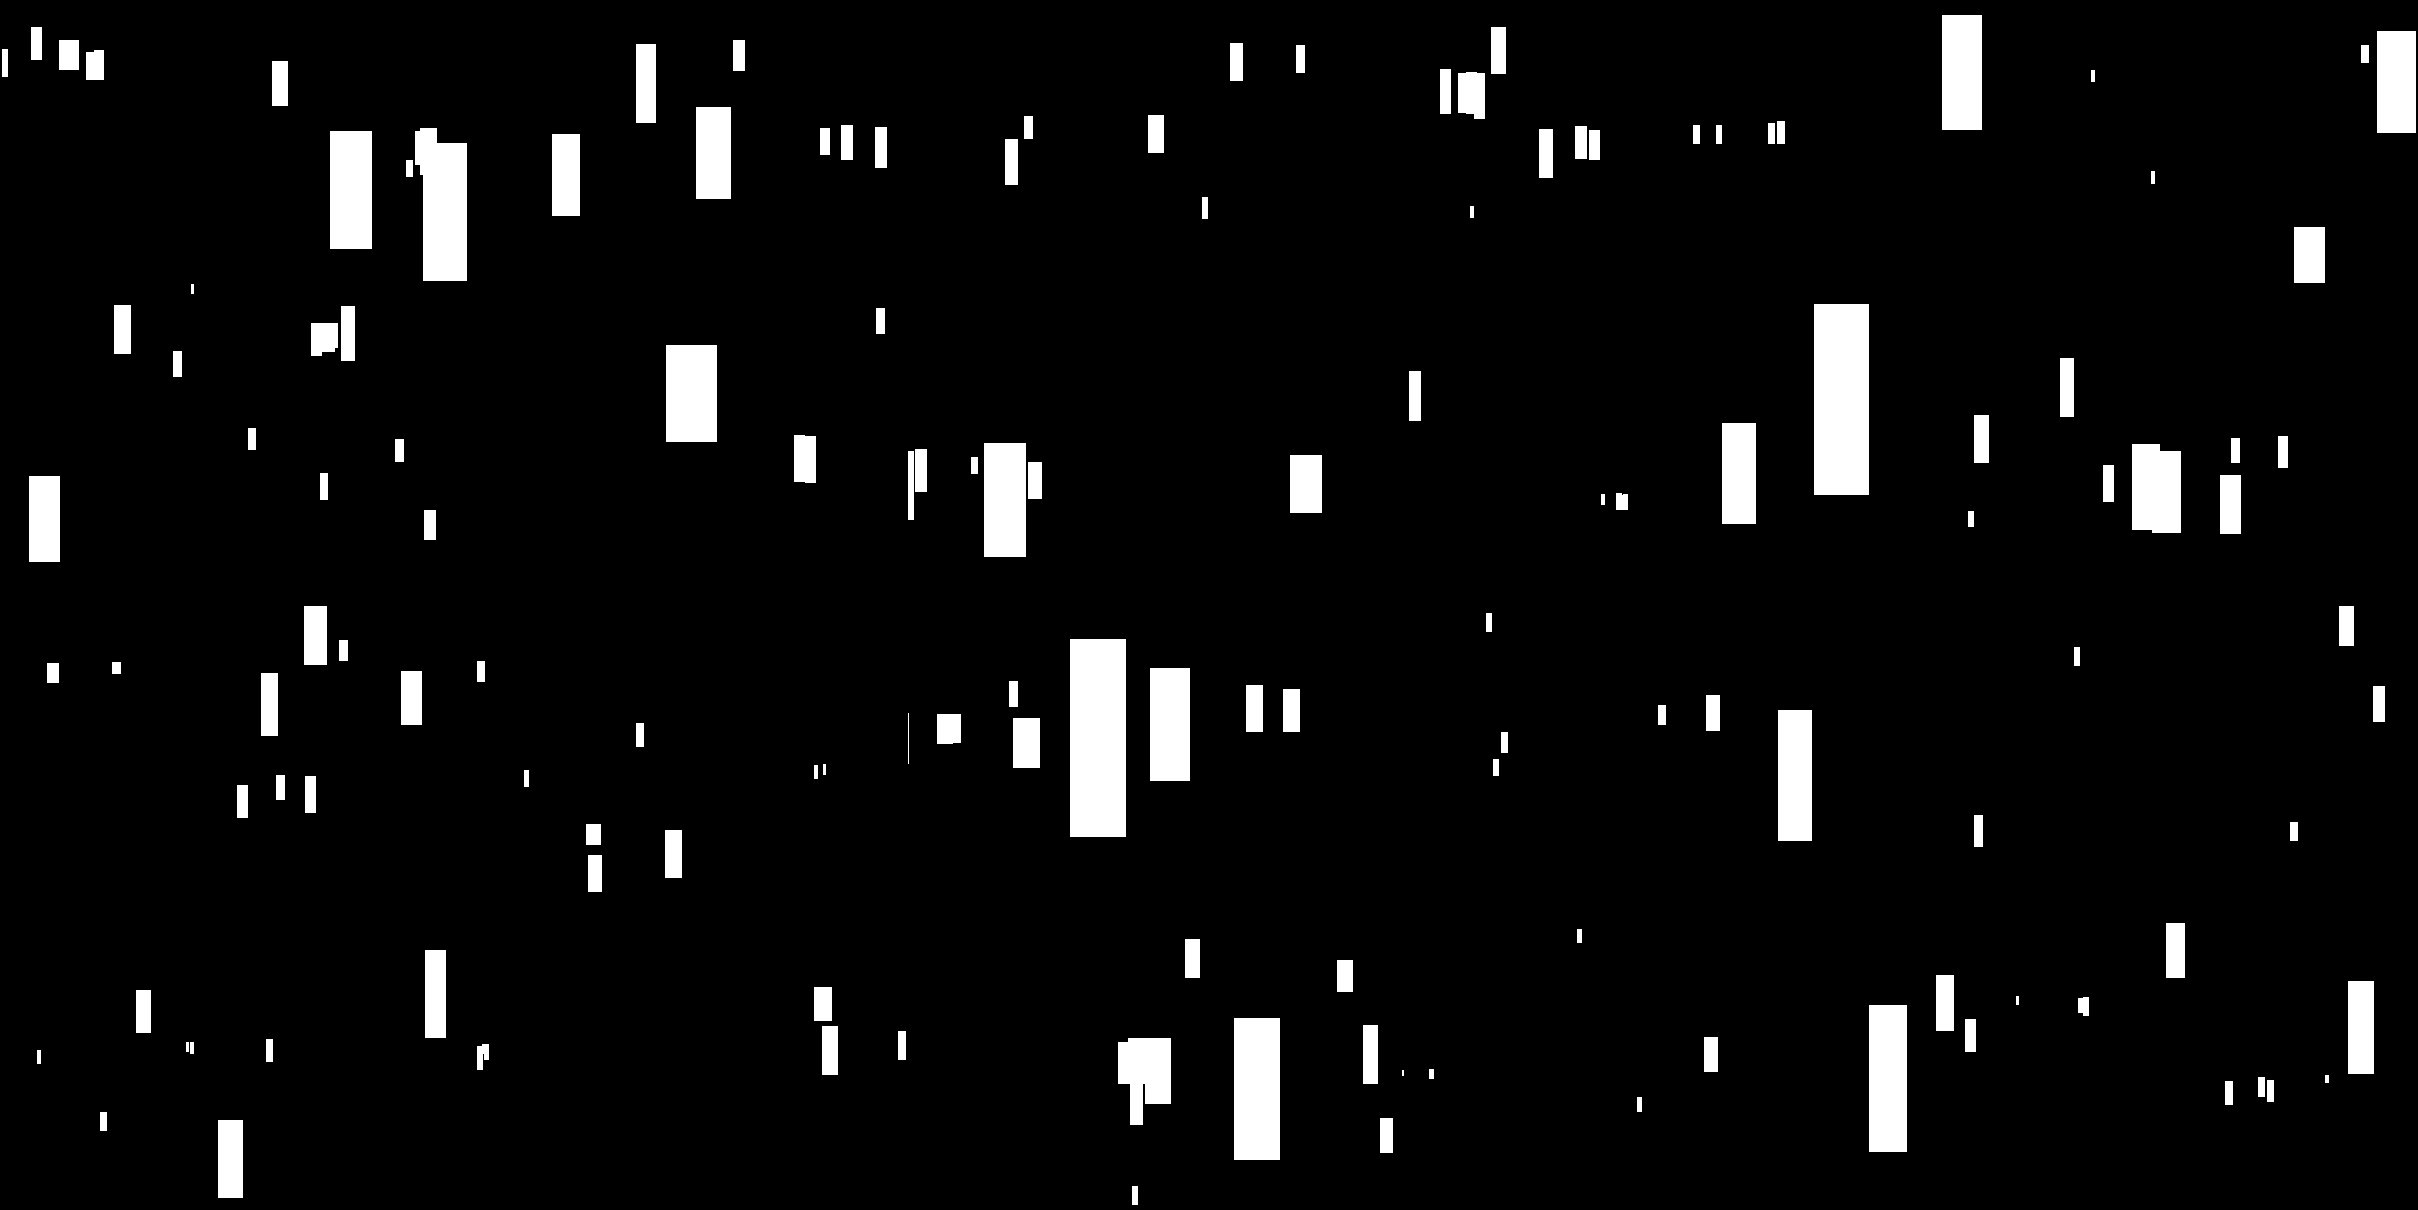

In [20]:
TF.to_pil_image(make_grid(seg_labels))

In [21]:
bboxes[0]

tensor([[0.8990, 0.1944, 0.9507, 0.3426],
        [0.2783, 0.1667, 0.3079, 0.2562],
        [0.3054, 0.1574, 0.3374, 0.2562],
        [0.0967, 0.0833, 0.1333, 0.1933],
        [0.1900, 0.1267, 0.2567, 0.2267],
        [0.6300, 0.9400, 0.6400, 0.9733]])

In [22]:
category_ids[0]

tensor([1, 1, 1, 1, 1, 1])